**Exercise 2.** Switch loss functions (perhaps MSE).

a. Does the training behavior change?

b. Is it possible to reduce the capacity of the network enough that it stops overfitting?

c. How does the model perform on the validation set when doing so?

Since this is a binary classification problem, using mean squared error as our loss function doesn't seem appropriate.

Rather, let's switch from `nn.CrossEntropyLoss` to `nn.BCEWithLogitsLoss`. Accordingly, we'll change the number of output units of the last linear layer from 2 to 1.

For binary classification problems, these two formulations are mathematically equivalent:

- 2 output units with `nn.CrossEntropyLoss`
- 1 output unit with `nn.BCEWithLogitsLoss`


Hence, the training behavior shouldn't change.

In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [2]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


If running this notebook in Colab, please ensure that your Hugging Face `HF_TOKEN` and your Weights & Biases `WANDB_API_KEY` are added to your Colab secrets.

Alternatively, please login to Hugging Face and Weights & Biases by running the following two cells.

In [3]:
# !huggingface-cli login

In [4]:
# !wandb login

In [5]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [6]:
from datasets import load_dataset

cifar10 = load_dataset("cifar10")
cifar10

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [7]:
features = cifar10['train'].features
features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [8]:
id2label = {id: label for id, label in enumerate(features['label'].names)}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [9]:
example = cifar10['train'][0]
example

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

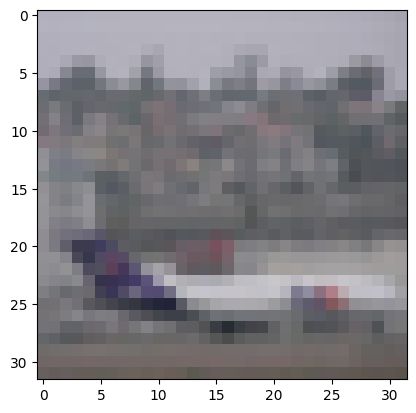

In [10]:
import matplotlib.pyplot as plt

plt.imshow(example['img']);

In [11]:
example['label']

0

In [12]:
id2label[example['label']]

'airplane'

Now, let's create a PyTorch `Dataset` for model training.

In [13]:
from torch.utils.data import Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, tfms):
        self.dataset = dataset
        self.tfms = tfms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        img, label = example['img'], example['label']
        img = self.tfms(img)
        return img, label

**Note:** There is no need to convert `label` to a tensor as the data collator will collate the integers into a tensor anyway.

In [14]:
from torchvision.transforms import v2

tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616])
])

**Note:** `ToImage()` along with `ToDtype(torch.float32, scale=True)` is a replacement for `ToTensor()` in `torchvision.transforms.v2`.

In [15]:
cifar10_train = CIFAR10Dataset(cifar10['train'], tfms)
len(cifar10_train)

50000

In [16]:
# Sanity check:
img, label = cifar10_train[0]
img.shape, label

(torch.Size([3, 32, 32]), 0)

In [17]:
cifar10_val = CIFAR10Dataset(cifar10['test'], tfms)
len(cifar10_val)

10000

In [18]:
# Sanity check:
img, label = cifar10_val[0]
img.shape, label

(torch.Size([3, 32, 32]), 3)

In [19]:
label_map = {0: 0.0, 2: 1.0}
class_names = ['airplane', 'bird']

**Note:** Unlike `nn.CrossEntropyLoss`, `nn.BCEWithLogitsLoss` expects the target tensor to contain floats (not integers).

In [20]:
cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in [0, 2]]
len(cifar2_train)

10000

In [21]:
# Sanity check:
img, label = cifar2_train[0]
img.shape, label

(torch.Size([3, 32, 32]), 0.0)

In [22]:
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]
len(cifar2_val)

2000

In [23]:
# Sanity check:
img, label = cifar2_val[0]
img.shape, label

(torch.Size([3, 32, 32]), 0.0)

In [24]:
batch_size = 64

In [25]:
from torch.utils.data import DataLoader

train_dl = DataLoader(cifar2_train, batch_size=batch_size, shuffle=True, num_workers=2)
len(train_dl)

157

In [26]:
# Sanity check:
imgs, labels = next(iter(train_dl))
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [27]:
imgs.dtype, labels.dtype

(torch.float32, torch.float64)

In [28]:
val_dl = DataLoader(cifar2_val, batch_size=batch_size, shuffle=False, num_workers=2)
len(val_dl)

32

In [29]:
# Sanity check:
imgs, labels = next(iter(val_dl))
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [30]:
imgs.dtype, labels.dtype

(torch.float32, torch.float64)

Now, let's define our multi-layer perceptron.

In [31]:
3 * 32 * 32

3072

In [32]:
import torch.nn as nn

class MLPForCIFAR2(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3072, 1024), # Hidden layer.
            nn.Tanh(),
            nn.Linear(1024, 512), # Hidden layer.
            nn.Tanh(),
            nn.Linear(512, 128), # Hidden layer.
            nn.Tanh(),
            nn.Linear(128, 1) # Output layer.
        )

    def forward(self, x):
        return self.mlp(x)

model = MLPForCIFAR2()
model

MLPForCIFAR2(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [33]:
# Sanity check:
with torch.no_grad():
    batch_dim = imgs.shape[0]
    logits = model(imgs.view(batch_dim, -1)) # Flatten.
logits.shape

torch.Size([64, 1])

In [34]:
loss_fn = nn.BCEWithLogitsLoss()

In [35]:
# Sanity check:
with torch.no_grad():
    loss = loss_fn(logits.squeeze(), labels)
loss

tensor(0.7016, dtype=torch.float64)

**Note:** `nn.BCEWithLogitsLoss` expects the logits and the labels to have the same shape.

In [36]:
from torch.optim import SGD

learning_rate = 1e-2
optimizer = SGD(model.parameters(), lr=learning_rate)
n_epochs = 100

In [37]:
def train_epoch():
    model.train()
    train_loss = 0
    for imgs, labels in train_dl:
        batch_dim = imgs.shape[0]
        logits = model(imgs.view(batch_dim, -1))
        loss = loss_fn(logits.squeeze(), labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(cifar2_train)
    train_loss = round(train_loss, 4)
    return train_loss

In [38]:
import torch.nn.functional as F

def validate_epoch():
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            batch_dim = imgs.shape[0]
            logits = model(imgs.view(batch_dim, -1))
            loss = loss_fn(logits.squeeze(), labels)
            val_loss += loss.item()
            proba = F.sigmoid(logits.squeeze())
            preds = proba > 0.5
            correct += (preds == labels).sum().item()
        val_loss /= len(cifar2_val)
        val_loss = round(val_loss, 4)
        acc = round(correct / len(cifar2_val), 4)
    return val_loss, acc

In [39]:
import wandb

wandb.init(
    project="mlp-cifar2-v2",
    config={
        'architecture': "MLP with 3 hidden layers",
        'dataset': "CIFAR-2",
        'learning_rate': learning_rate,
        'n_epochs': n_epochs,
        'batch_size': batch_size
    }
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [40]:
best_epoch = 0
best_acc = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

    val_loss, acc = validate_epoch()
    print(f"Validation Loss: {val_loss}, Accuracy: {acc}")

    wandb.log({
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': acc
    })

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc

    print("---")
wandb.finish()
print("---")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch: 0, Training Loss: 0.0087
Validation Loss: 0.0081, Accuracy: 0.7685
---
Epoch: 1, Training Loss: 0.0078
Validation Loss: 0.0077, Accuracy: 0.7785
---
Epoch: 2, Training Loss: 0.0075
Validation Loss: 0.0077, Accuracy: 0.784
---
Epoch: 3, Training Loss: 0.0073
Validation Loss: 0.0073, Accuracy: 0.7925
---
Epoch: 4, Training Loss: 0.0072
Validation Loss: 0.0073, Accuracy: 0.7985
---
Epoch: 5, Training Loss: 0.007
Validation Loss: 0.0074, Accuracy: 0.7965
---
Epoch: 6, Training Loss: 0.0069
Validation Loss: 0.0071, Accuracy: 0.8015
---
Epoch: 7, Training Loss: 0.0068
Validation Loss: 0.007, Accuracy: 0.8065
---
Epoch: 8, Training Loss: 0.0066
Validation Loss: 0.007, Accuracy: 0.805
---
Epoch: 9, Training Loss: 0.0065
Validation Loss: 0.007, Accuracy: 0.806
---
Epoch: 10, Training Loss: 0.0064
Validation Loss: 0.0073, Accuracy: 0.799
---
Epoch: 11, Training Loss: 0.0063
Validation Loss: 0.0069, Accuracy: 0.811
---
Epoch: 12, Training Loss: 0.0062
Validation Loss: 0.007, Accuracy: 0.80

accuracy,▆▇▇█▇██▇█▄▅▇█▆██▇█▅▇███▇▁▆██████▄█████▇▇
train_loss,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▂▁▂▂▂▂█▃▂▂▃▂▂▃▅▂▂▃▃▃▃▃
accuracy,0.803
train_loss,0.0
val_loss,0.0158


---
Best Epoch: 55, Best Accuracy: 0.8215


Answer to (a): Using `nn.BCEWithLogitsLoss` gives a slightly better accuracy than using `nn.CrossEntropyLoss`, which gave an accuracy of 0.801. (**Reference notebook:** https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch7/2_birds_airplanes.ipynb)

Now, let's reduce the capacity of the network by getting rid of one hidden layer.

In [41]:
class MLPForCIFAR2(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3072, 1024), # Hidden layer.
            nn.Tanh(),
            nn.Linear(1024, 128), # Hidden layer.
            nn.Tanh(),
            nn.Linear(128, 1) # Output layer.
        )

    def forward(self, x):
        return self.mlp(x)

model = MLPForCIFAR2()
model

MLPForCIFAR2(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

Let's re-instantiate the optimizer, and run our training loop.

In [42]:
optimizer = SGD(model.parameters(), lr=learning_rate)

In [43]:
wandb.init(
    project="mlp-cifar2-v2",
    config={
        'architecture': "MLP with 2 hidden layers",
        'dataset': "CIFAR-2",
        'learning_rate': learning_rate,
        'n_epochs': n_epochs,
        'batch_size': batch_size
    }
)

wandb: Currently logged in as: sadhaklal. Use `wandb login --relogin` to force relogin


In [44]:
best_epoch = 0
best_acc = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

    val_loss, acc = validate_epoch()
    print(f"Validation Loss: {val_loss}, Accuracy: {acc}")

    wandb.log({
        'train_loss': train_loss,
        'validation_loss': val_loss,
        'accuracy': acc
    })

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc

    print("---")
wandb.finish()
print("---")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch: 0, Training Loss: 0.0083
Validation Loss: 0.0079, Accuracy: 0.774
---
Epoch: 1, Training Loss: 0.0076
Validation Loss: 0.0076, Accuracy: 0.7845
---
Epoch: 2, Training Loss: 0.0074
Validation Loss: 0.0079, Accuracy: 0.7735
---
Epoch: 3, Training Loss: 0.0072
Validation Loss: 0.0073, Accuracy: 0.7975
---
Epoch: 4, Training Loss: 0.007
Validation Loss: 0.0071, Accuracy: 0.805
---
Epoch: 5, Training Loss: 0.0068
Validation Loss: 0.007, Accuracy: 0.8055
---
Epoch: 6, Training Loss: 0.0067
Validation Loss: 0.007, Accuracy: 0.806
---
Epoch: 7, Training Loss: 0.0066
Validation Loss: 0.0087, Accuracy: 0.715
---
Epoch: 8, Training Loss: 0.0065
Validation Loss: 0.0071, Accuracy: 0.806
---
Epoch: 9, Training Loss: 0.0064
Validation Loss: 0.007, Accuracy: 0.8105
---
Epoch: 10, Training Loss: 0.0063
Validation Loss: 0.007, Accuracy: 0.806
---
Epoch: 11, Training Loss: 0.0062
Validation Loss: 0.0074, Accuracy: 0.799
---
Epoch: 12, Training Loss: 0.0061
Validation Loss: 0.0069, Accuracy: 0.811


accuracy,▆▆▇▃▇██▂▇▆▆▄▆▇▁▃█▅██▇▇▇█▇█▆▇▅▇█▇█▇▇█████
train_loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁
validation_loss,▂▂▁▃▁▁▁▄▂▄▂▄▂▂█▆▂▄▃▃▄▃▃▄▄▄█▇█▅▆▅▆▆▆▆▇▇▇▇
accuracy,0.8095
train_loss,0.0001
validation_loss,0.0131


---
Best Epoch: 19, Best Accuracy: 0.8245


Reducing the capacity of the network (from three hidden layer to two hidden layers) leads to a tiny improvement in accuracy.

Let's try reducing the capacity of the network further to just a single hidden layer. We'll also reduce the number of units in the hidden layer to just 64.

In [45]:
from huggingface_hub import PyTorchModelHubMixin

class MLPForCIFAR2(nn.Module, PyTorchModelHubMixin):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3072, 64), # Hidden layer.
            nn.Tanh(),
            nn.Linear(64, 1) # Output layer.
        )

    def forward(self, x):
        return self.mlp(x)

model = MLPForCIFAR2()
model

MLPForCIFAR2(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

Let's re-instantiate the optimizer, and run our training loop.

In [46]:
optimizer = SGD(model.parameters(), lr=learning_rate)

In [47]:
wandb.init(
    project="mlp-cifar2-v2",
    config={
        'architecture': "MLP with 1 hidden layer",
        'dataset': "CIFAR-2",
        'learning_rate': learning_rate,
        'n_epochs': n_epochs,
        'batch_size': batch_size
    }
)

In [48]:
best_epoch = 0
best_acc = 0
for epoch in range(n_epochs):
    train_loss = train_epoch()
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

    val_loss, acc = validate_epoch()
    print(f"Validation Loss: {val_loss}, Accuracy: {acc}")

    wandb.log({
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': acc
    })

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc
        model.push_to_hub("mlp-cifar2-v2", commit_message=f"epoch: {epoch}, accuracy: {acc}")

    print("---")
wandb.finish()
print("---")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch: 0, Training Loss: 0.0081
Validation Loss: 0.0078, Accuracy: 0.7815


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 1, Training Loss: 0.0075
Validation Loss: 0.0076, Accuracy: 0.771
---
Epoch: 2, Training Loss: 0.0073
Validation Loss: 0.0074, Accuracy: 0.794


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 3, Training Loss: 0.0071
Validation Loss: 0.0073, Accuracy: 0.785
---
Epoch: 4, Training Loss: 0.0069
Validation Loss: 0.0072, Accuracy: 0.7995


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 5, Training Loss: 0.0068
Validation Loss: 0.007, Accuracy: 0.8025


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 6, Training Loss: 0.0067
Validation Loss: 0.007, Accuracy: 0.8025
---
Epoch: 7, Training Loss: 0.0066
Validation Loss: 0.009, Accuracy: 0.7065
---
Epoch: 8, Training Loss: 0.0065
Validation Loss: 0.0068, Accuracy: 0.813


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 9, Training Loss: 0.0064
Validation Loss: 0.007, Accuracy: 0.8025
---
Epoch: 10, Training Loss: 0.0063
Validation Loss: 0.0068, Accuracy: 0.8095
---
Epoch: 11, Training Loss: 0.0062
Validation Loss: 0.0067, Accuracy: 0.8145


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 12, Training Loss: 0.0061
Validation Loss: 0.0067, Accuracy: 0.8105
---
Epoch: 13, Training Loss: 0.006
Validation Loss: 0.0067, Accuracy: 0.8115
---
Epoch: 14, Training Loss: 0.0059
Validation Loss: 0.007, Accuracy: 0.802
---
Epoch: 15, Training Loss: 0.0058
Validation Loss: 0.0066, Accuracy: 0.819


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 16, Training Loss: 0.0057
Validation Loss: 0.0068, Accuracy: 0.817
---
Epoch: 17, Training Loss: 0.0056
Validation Loss: 0.0067, Accuracy: 0.818
---
Epoch: 18, Training Loss: 0.0055
Validation Loss: 0.0067, Accuracy: 0.8125
---
Epoch: 19, Training Loss: 0.0054
Validation Loss: 0.0065, Accuracy: 0.8225


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 20, Training Loss: 0.0053
Validation Loss: 0.0067, Accuracy: 0.812
---
Epoch: 21, Training Loss: 0.0053
Validation Loss: 0.0067, Accuracy: 0.8135
---
Epoch: 22, Training Loss: 0.0051
Validation Loss: 0.0067, Accuracy: 0.822
---
Epoch: 23, Training Loss: 0.005
Validation Loss: 0.0065, Accuracy: 0.821
---
Epoch: 24, Training Loss: 0.0049
Validation Loss: 0.0066, Accuracy: 0.821
---
Epoch: 25, Training Loss: 0.0048
Validation Loss: 0.0072, Accuracy: 0.795
---
Epoch: 26, Training Loss: 0.0047
Validation Loss: 0.0066, Accuracy: 0.8165
---
Epoch: 27, Training Loss: 0.0046
Validation Loss: 0.0064, Accuracy: 0.829


pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

---
Epoch: 28, Training Loss: 0.0045
Validation Loss: 0.0065, Accuracy: 0.818
---
Epoch: 29, Training Loss: 0.0044
Validation Loss: 0.0067, Accuracy: 0.8265
---
Epoch: 30, Training Loss: 0.0044
Validation Loss: 0.0065, Accuracy: 0.824
---
Epoch: 31, Training Loss: 0.0043
Validation Loss: 0.0065, Accuracy: 0.828
---
Epoch: 32, Training Loss: 0.0042
Validation Loss: 0.0066, Accuracy: 0.818
---
Epoch: 33, Training Loss: 0.0041
Validation Loss: 0.0065, Accuracy: 0.825
---
Epoch: 34, Training Loss: 0.004
Validation Loss: 0.0065, Accuracy: 0.8245
---
Epoch: 35, Training Loss: 0.0039
Validation Loss: 0.0065, Accuracy: 0.8285
---
Epoch: 36, Training Loss: 0.0038
Validation Loss: 0.0065, Accuracy: 0.8245
---
Epoch: 37, Training Loss: 0.0037
Validation Loss: 0.0079, Accuracy: 0.765
---
Epoch: 38, Training Loss: 0.0036
Validation Loss: 0.0066, Accuracy: 0.816
---
Epoch: 39, Training Loss: 0.0035
Validation Loss: 0.0066, Accuracy: 0.816
---
Epoch: 40, Training Loss: 0.0034
Validation Loss: 0.0065,

accuracy,▅▆▆▁▇▇▇▇▇█▆████▇███▇▇▇▇▃▇▇▇▅▇█▇▇▇▇▇▇▆▇▇▇
train_loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▅▄▃█▂▂▂▂▂▂▃▁▁▁▁▂▁▂▁▂▂▂▂█▃▄▃▆▃▄▄▄▅▄▇▅▇▅▅▆
accuracy,0.8125
train_loss,0.0008
val_loss,0.0082


---
Best Epoch: 27, Best Accuracy: 0.829


Let's reload the weights of the best epoch, and then calculate the metrics on the training set and the validation set.

In [49]:
model = MLPForCIFAR2.from_pretrained("sadhaklal/mlp-cifar2-v2")
model.eval()

pytorch_model.bin:   0%|          | 0.00/789k [00:00<?, ?B/s]

MLPForCIFAR2(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [50]:
# Training set accuracy:
correct = 0
with torch.no_grad():
    for imgs, labels in train_dl:
        batch_dim = imgs.shape[0]
        logits = model(imgs.view(batch_dim, -1))
        proba = F.sigmoid(logits.squeeze())
        preds = proba > 0.5
        correct += (preds == labels).sum().item()
print(f"Accuracy: {correct / len(cifar2_train):.4f}")

Accuracy: 0.8917


In [51]:
# Validation set accuracy:
correct = 0
with torch.no_grad():
    for imgs, labels in val_dl:
        batch_dim = imgs.shape[0]
        logits = model(imgs.view(batch_dim, -1))
        proba = F.sigmoid(logits.squeeze())
        preds = proba > 0.5
        correct += (preds == labels).sum().item()
print(f"Accuracy: {correct / len(cifar2_val):.4f}")

Accuracy: 0.8290


Answer to (b) and (c): Reducing the capacity of the network doesn't seem to "stop" overfitting. However, it seems to slightly reduce the extent of overfitting. The accuracy on the validation set increases slightly.